# INSIGHTS

As anotações e documentação dos testes estão no Maxtrade


#### Bibliotecas

In [1]:
import AiUtils
from AiUtils import * 

# BASIC
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import joblib

# CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# PRE-PROCESSING
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

#METRICS
from sklearn import metrics

# STATISTIC
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# WARNING
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
# MINI INDICE - METATRADER
# DATASET ##############################################################################
base = pd.read_csv('WDO$_M5_202103101400_202410181825.csv', sep='\t')
base.drop(columns=['<SPREAD>'], inplace=True)
base.rename(columns={
            '<DATE>': 'Date', 
            '<TIME>': 'Time', 
            '<OPEN>': 'Open', 
            '<HIGH>': 'High', 
            '<LOW>' : 'Low', 
            '<CLOSE>': 'Close', 
            '<TICKVOL>':'Tick', 
            '<VOL>': 'Volume'}, inplace = True)
base['Datetime'] = base['Date']+' '+base['Time']
#base['Datetime'] = pd.to_datetime(base['Datetime'], utc=True)
base = base[base['Date']<base['Date'].max()]
base.set_index(base['Date']+' '+base['Time'], inplace=True)

In [3]:
base.shape

(99886, 9)

In [4]:
base.tail()

Date      Time    Open    High     Low   Close   
2024.10.17 18:05:00  2024.10.17  18:05:00  5664.5  5665.0  5663.5  5664.5  \
2024.10.17 18:10:00  2024.10.17  18:10:00  5665.0  5665.0  5663.0  5664.0   
2024.10.17 18:15:00  2024.10.17  18:15:00  5664.0  5665.0  5662.0  5662.5   
2024.10.17 18:20:00  2024.10.17  18:20:00  5662.5  5664.0  5661.0  5662.0   
2024.10.17 18:25:00  2024.10.17  18:25:00  5662.0  5664.5  5660.5  5660.5   

                     Tick  Volume             Datetime  
2024.10.17 18:05:00   523    2562  2024.10.17 18:05:00  
2024.10.17 18:10:00   876    3447  2024.10.17 18:10:00  
2024.10.17 18:15:00  1474    5880  2024.10.17 18:15:00  
2024.10.17 18:20:00   882    3344  2024.10.17 18:20:00  
2024.10.17 18:25:00   896    6364  2024.10.17 18:25:00

In [5]:
# SEPARARANDO OS DADOS PARA AVALIAÇÃO COM DADOS FUTUROS
df_evaluate = base[base['Date']== base['Date'].max()]

In [6]:
df_base = base[base['Date']< base['Date'].max()]
df_base = df_base[['Open', 'High', 'Low', 'Close', 'Tick', 'Volume']]

In [7]:
df_base.shape

(99772, 6)

In [8]:
# AVALIANDO A RELAÇÃO DE VOLUME X TICK
#df_base['VolTick'] = df_base['Volume'] / df_base['Tick']

# AVALIANDO A VARIAÇÃO % DAS INFORMAÇÕES DO CANDLE

#df_base['InnerVar_High'] = (df_base['High'] - df_base['Open']) / df_base['Open'] * 100
#df_base['InnerVar_Low'] = (df_base['Open']  - df_base['Low']) / df_base['Open'] * 100
#df_base['InnerVar_Close'] = np.where(df_base['Close']>df_base['Open'], (df_base['Close'] - df_base['Open']) / df_base['Open'] *100, (df_base['Open']  - df_base['Close']) / df_base['Open']*100)

In [9]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

NameError: name 'data' is not defined

In [10]:
df_base.shape

(99772, 6)

In [11]:
df_base.tail()

Open    High     Low   Close  Tick  Volume
2024.10.16 18:05:00  5674.0  5674.0  5672.5  5673.0   435    1527
2024.10.16 18:10:00  5673.5  5674.5  5673.0  5673.0   804    2549
2024.10.16 18:15:00  5673.5  5676.5  5673.0  5674.5  1404    6051
2024.10.16 18:20:00  5674.0  5675.5  5674.0  5675.5   633    2463
2024.10.16 18:25:00  5675.0  5679.0  5674.0  5679.0   801    3973

In [12]:
# TIMEFRAME

time_frame = 7

#BASE MINUTOS DIARIO 510 
#BASE HORAS POR PREGAO DIARIO: 7
#BASE MESES PREGAO ANO: 12

# https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b
df_log = np.log(df_base)
ma_log = df_log.rolling(time_frame).mean()

#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()

## start solução vini - tratamento dos nulos para manter o tamanho da base
#df_sub = (df_log - ma_log)
#df_sub.fillna(0, inplace=True)
#df_sub.fillna(method='ffill', inplace=True)
## end solução vini


ma_sub = df_sub.rolling(time_frame).mean()
#desvio padrão
std_sub = df_sub.rolling(time_frame).std()

#Diferenciação
#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(time_frame).mean()
#desvio padrão
std_diff = df_diff.rolling(time_frame).std()
#df_diff = df_diff.dropna()
df_diff['return_percent'] = df_diff['Close'].pct_change()
m_df = df_diff.copy()

In [13]:
m_df.shape

(99766, 7)

In [14]:
#-----------------------------------FEATURE ENGINEERING--------------------------------------------
#m_df = criar_rsi(m_df) # 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi'
#m_df = suporte_resistencia(m_df) #'suport_resistencia'
m_df = lta_ltb(m_df) # 'corr', 'corr_class'
m_df = criar_bollinger(m_df) #'upper', 'mid', 'low','bbp'
m_df = media_movel(m_df, 'Close', 20) # 'media_movel'


In [15]:
m_df.shape

(99723, 14)

In [16]:
###-----------------------------------FUNÇÃO DO MODELO-------------------------------------------- '''
### included in AiUtils

In [17]:
##-----------------------------------CRIANDO DATASET-------------------------------------------- '''
hora_previsao = 1


#alvos = 8 # adicionei a variavel alvos para realizar um predict para alvos futuros 
m_df = target(m_df)
#m_df = target(m_df, alvos)


m_df.dropna(inplace=True) #, 'bbp', 'corr_class' 
#m_df = m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
m_df = m_df[['bbp', 'corr_class', 'target', 'Close', 'media_movel', 'Tick', 'Volume']]
            #'VolTick','InnerVar_High', 'InnerVar_Low', 'InnerVar_Close'
#'suport_resistencia', 'dia_semana', 'horario', 'mes'

m_df = constroi_features_defasadas(m_df,['Close'], 20) # rsi, bbp, temporais, lta/ltb, suporte resitesncia
m_df = constroi_features_futuras(m_df,'target', hora_previsao)
m_df = m_df.drop('target', axis=1)
m_df = m_df.dropna()
#m_df.fillna(method='ffill', inplace=True)

### Normalização

In [18]:
scaler = MinMaxScaler()#StandardScaler() #MinMaxScaler()

In [19]:
#'dia_semana','horario', 'mes'
m_df = m_df.loc[:,['bbp','corr_class', 'media_movel', 'Tick', 'Volume',
                #'VolTick','InnerVar_High', 'InnerVar_Low', 'InnerVar_Close',
                'Close','Close_def_1', 'Close_def_2',
                'Close_def_3', 'Close_def_4', 'Close_def_5',
                'Close_def_6', 'Close_def_7', 'Close_def_8',
                'Close_def_9', 'Close_def_10', 'Close_def_11',
                'Close_def_12', 'Close_def_13', 'Close_def_14',
                'Close_def_15', 'Close_def_16', 'Close_def_17',
                'Close_def_18', 'Close_def_19', 'Close_def_20','target_fut']]

In [20]:
x_train, x_test, y_train, y_test = preprocessamento(m_df, m_df.index[round(len(m_df.index) * 0.8)], 'target_fut')
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

##### MODELOS CANDIDATOS - ANDRÉ

In [21]:
# ALVO 1
avaliacao_modelos(modelos_candidatos, x_train, y_train)

({'Árvore': 0.6721540892333159,
  'RandomForest': 0.7551275299074561,
  'XGBoost': 0.7581822285757279},
 [0.6721540892333159, 0.7551275299074561, 0.7581822285757279])

### MEUS MODELOS

### Logistic Regression

In [22]:
lrc = LogisticRegression(random_state=42, class_weight='balanced')
lrc.fit(x_train, y_train)

y1_pred = lrc.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, y1_pred))



Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.77      0.77      9966
         1.0       0.77      0.77      0.77      9970

    accuracy                           0.77     19936
   macro avg       0.77      0.77      0.77     19936
weighted avg       0.77      0.77      0.77     19936



### Random Forest

In [23]:
# fitando o modelo
rfc = RandomForestClassifier(random_state=42, max_depth=5, class_weight='balanced') 
rfc.fit(x_train, y_train)

y1_pred = rfc.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, y1_pred))


Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.77      0.76      9966
         1.0       0.76      0.74      0.75      9970

    accuracy                           0.76     19936
   macro avg       0.76      0.76      0.76     19936
weighted avg       0.76      0.76      0.76     19936



In [ ]:
checagem = pd.DataFrame(y1_pred)

In [ ]:
checagem.iloc[:,0].value_counts()

In [ ]:
len(x_train), len(x_test)

### XGBOOST

In [193]:
# fitando o modelo
xgb = XGBClassifier(random_state=42, max_depth=5) 
#xgb = XGBClassifier(random_state=42, gamma = 0.75, max_depth=5, n_estimators=50)
xgb.fit(x_train, y_train)

y1_pred = xgb.predict(x_test)
print('\nClassification Report\n', metrics.classification_report(y_test, y1_pred))


Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.77      0.77      9966
         1.0       0.77      0.77      0.77      9970

    accuracy                           0.77     19936
   macro avg       0.77      0.77      0.77     19936
weighted avg       0.77      0.77      0.77     19936



## EXPORTANDO O MODELO

In [24]:
ativo = 'WDO-2024' #LTCUSD, MINI-INDICE

In [25]:
#path = 'C:/_PY/Trade_NB/_Profit/'

In [26]:
#joblib.dump(mdl_2, path + 'model_'+ ativo +'.pkl')
joblib.dump(rfc,'model_'+ ativo +'.pkl')

['model_WDO-2024.pkl']

## IMPORTANDO O MODELO

In [27]:
#path = 'C:/_PY/Trade_NB/IQOPTION/'

In [28]:
model = joblib.load('model_'+ ativo +'.pkl')

In [29]:
model

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

## Avaliar os Resultados considerando dados futuros

In [30]:
# REALIZANDO AS TRANSFORMAÇÕES NECESSÁRIAS A EXEMPLO DO MODELO JÁ TREINADO

#carregando os candles do penultimo dia para ter uma visão completa do Evaluate (114 do dia + 40 candles anteriores)
adjust = base[base['Date']< base['Date'].max()]
adjust = adjust[adjust['Date']== adjust['Date'].max()]

#new_df = df_evaluate.copy()
new_df = pd.concat([adjust[-40:], df_evaluate])

new_df = new_df[['Open', 'High', 'Low', 'Close', 'Tick', 'Volume']]
#new_df['VolTick'] = new_df['Volume'] / new_df['Tick']
#new_df['InnerVar_High'] = (new_df['High'] - new_df['Open']) / new_df['Open'] * 100
#new_df['InnerVar_Low'] = (new_df['Open']  - new_df['Low']) / new_df['Open'] * 100
#new_df['InnerVar_Close'] = np.where(new_df['Close']>new_df['Open'], (new_df['Close'] - new_df['Open']) / new_df['Open'] *100, (new_df['Open']  - new_df['Close']) / new_df['Open']*100)


In [31]:

# TIMEFRAME

time_frame = 7

#BASE MINUTOS DIARIO 510 
#BASE HORAS POR PREGAO DIARIO: 7
#BASE MESES PREGAO ANO: 12

# https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b
df_log = np.log(new_df)
ma_log = df_log.rolling(time_frame).mean()

In [32]:
ma_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 2024.10.16 15:10:00 to 2024.10.17 18:25:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    148 non-null    float64
 1   High    148 non-null    float64
 2   Low     148 non-null    float64
 3   Close   148 non-null    float64
 4   Tick    148 non-null    float64
 5   Volume  148 non-null    float64
dtypes: float64(6)
memory usage: 8.4+ KB


In [33]:


#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()

## start solução vini - tratamento dos nulos para manter o tamanho da base
#df_sub = (df_log - ma_log)
#df_sub.fillna(0, inplace=True)
#df_sub.fillna(method='ffill', inplace=True)
## end solução vini


ma_sub = df_sub.rolling(time_frame).mean()
#desvio padrão
std_sub = df_sub.rolling(time_frame).std()

#Diferenciação
#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(time_frame).mean()
#desvio padrão
std_diff = df_diff.rolling(time_frame).std()
#df_diff = df_diff.dropna()
df_diff['return_percent'] = df_diff['Close'].pct_change()
new_m_df = df_diff.copy()
new_m_df = lta_ltb(new_m_df) # 'corr', 'corr_class'
new_m_df = criar_bollinger(new_m_df) #'upper', 'mid', 'low','bbp'
new_m_df = media_movel(new_m_df, 'Close', 20) # 'media_movel'
hora_previsao = 1


new_m_df = target(new_m_df)

new_m_df.dropna(inplace=True) #, 'bbp', 'corr_class' 
#new_m_df = new_m_df[['bbp', 'corr_class','amplitude','body','pavil_call', 'pavil_put', 'retorno_volume', 'retorno','target', 'Close', 'Volume', 'rsi', 'suport_resistencia', 'media_movel', 'dia_semana', 'horario', 'mes']]
new_m_df = new_m_df[['bbp', 'corr_class', 'target', 'Close', 'media_movel', 'Tick', 'Volume']]
            #'VolTick','InnerVar_High', 'InnerVar_Low', 'InnerVar_Close'

#'suport_resistencia', 'dia_semana', 'horario', 'mes'

new_m_df = constroi_features_defasadas(new_m_df,['Close'], 20) # rsi, bbp, temporais, lta/ltb, suporte resitesncia
#new_m_df = constroi_features_futuras ... foi removido pois não é considerado para os dados futuros
new_m_df = new_m_df.drop('target', axis=1)
new_m_df = new_m_df.dropna()

scaler = MinMaxScaler()

new_m_df = new_m_df.loc[:,['bbp','corr_class', 'media_movel', 'Tick', 'Volume',
                #'VolTick','InnerVar_High', 'InnerVar_Low', 'InnerVar_Close',
                'Close','Close_def_1', 'Close_def_2',
                'Close_def_3', 'Close_def_4', 'Close_def_5',
                'Close_def_6', 'Close_def_7', 'Close_def_8',
                'Close_def_9', 'Close_def_10', 'Close_def_11',
                'Close_def_12', 'Close_def_13', 'Close_def_14',
                'Close_def_15', 'Close_def_16', 'Close_def_17',
                'Close_def_18', 'Close_def_19', 'Close_def_20']]

In [34]:
new_m_df

bbp  corr_class   media_movel      Tick    Volume   
2024.10.17 12:40:00  0.500336           0 -6.458869e-07 -0.202279 -0.358912  \
2024.10.17 12:45:00  0.243722           0  6.536072e-05 -0.359535 -0.429176   
2024.10.17 12:50:00  1.012463           0  7.409751e-05  1.272969  1.388997   
2024.10.17 12:55:00 -0.442993           0  4.398652e-06 -0.427108 -0.345734   
2024.10.17 13:00:00  0.776293           0  6.043007e-07  0.170410  0.287028   
...                       ...         ...           ...       ...       ...   
2024.10.17 18:05:00  0.565972           0  1.888532e-05 -0.254902  0.150708   
2024.10.17 18:10:00  0.310396           0  2.580454e-05  0.605542  0.402851   
2024.10.17 18:15:00 -0.159435           0  2.326655e-05  0.638799  0.651724   
2024.10.17 18:20:00  0.261167           0  3.334725e-05 -0.468492 -0.531898   
2024.10.17 18:25:00  0.107817           0  6.253231e-06  0.155667  0.717235   

                            Close   Close_def_1   Close_def_2   Close_def_3   
2024.10.17 12:40:00 -2.089276e-07 -2.516305e-05  6.911671e-04 -3.771806e-05  \
2024.10.17 12:45:00 -2.135522e-04 -2.089276e-07 -2.516305e-05  6.911671e-04   
2024.10.17 12:50:00  6.401266e-04 -2.135522e-04 -2.089276e-07 -2.516305e-05   
2024.10.17 12:55:00 -1.155098e-03  6.401266e-04 -2.135522e-04 -2.089276e-07   
2024.10.17 13:00:00  3.389851e-04 -1.155098e-03  6.401266e-04 -2.135522e-04   
...                           ...           ...           ...           ...   
2024.10.17 18:05:00  5.043055e-05  3.782458e-05  5.043055e-05  3.909631e-04   
2024.10.17 18:10:00 -6.305321e-05  5.043055e-05  3.782458e-05  5.043055e-05   
2024.10.17 18:15:00 -2.900964e-04 -6.305321e-05  5.043055e-05  3.782458e-05   
2024.10.17 18:20:00 -7.568925e-05 -2.900964e-04 -6.305321e-05  5.043055e-05   
2024.10.17 18:25:00 -1.640446e-04 -7.568925e-05 -2.900964e-04 -6.305321e-05   

                      Close_def_4  ...  Close_def_11  Close_def_12   
2024.10.17 12:40:00  7.533000e-05  ...     -0.000427      0.001080  \
2024.10.17 12:45:00 -3.771806e-05  ...     -0.000992     -0.000427   
2024.10.17 12:50:00  6.911671e-04  ...      0.000151     -0.000992   
2024.10.17 12:55:00 -2.516305e-05  ...     -0.000628      0.000151   
2024.10.17 13:00:00 -2.089276e-07  ...     -0.000755     -0.000628   
...                           ...  ...           ...           ...   
2024.10.17 18:05:00  2.522819e-04  ...      0.000063     -0.000240   
2024.10.17 18:10:00  3.909631e-04  ...      0.000151      0.000063   
2024.10.17 18:15:00  5.043055e-05  ...      0.000164      0.000151   
2024.10.17 18:20:00  3.782458e-05  ...     -0.000038      0.000164   
2024.10.17 18:25:00  5.043055e-05  ...      0.000151     -0.000038   

                     Close_def_13  Close_def_14  Close_def_15  Close_def_16   
2024.10.17 12:40:00      0.000641     -0.000415     -0.000088      0.000415  \
2024.10.17 12:45:00      0.001080      0.000641     -0.000415     -0.000088   
2024.10.17 12:50:00     -0.000427      0.001080      0.000641     -0.000415   
2024.10.17 12:55:00     -0.000992     -0.000427      0.001080      0.000641   
2024.10.17 13:00:00      0.000151     -0.000992     -0.000427      0.001080   
...                           ...           ...           ...           ...   
2024.10.17 18:05:00      0.000101      0.000340     -0.000076      0.000378   
2024.10.17 18:10:00     -0.000240      0.000101      0.000340     -0.000076   
2024.10.17 18:15:00      0.000063     -0.000240      0.000101      0.000340   
2024.10.17 18:20:00      0.000151      0.000063     -0.000240      0.000101   
2024.10.17 18:25:00      0.000164      0.000151      0.000063     -0.000240   

                     Close_def_17  Close_def_18  Close_def_19  Close_def_20  
2024.10.17 12:40:00      0.000239      0.000465     -0.001534      0.001018  
2024.10.17 12:45:00      0.000415      0.000239      0.000465     -0.001534  
2024.10.17 12:50:00     -0.000088      0.000415      0.000239      0.000465  
2024.10.17 12:55:00     -0

In [35]:
#Realizar o predict de um novo registro
X_test = new_m_df[-1:] # pega o ultimo registro da base
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [36]:
#Realizar o predict de um novo registro
X_testxgb = new_m_df[-1:] # pega o ultimo registro da base
y_predxgb = xgb.predict(X_test)
y_probaxgb = xgb.predict_proba(X_test)

NameError: name 'xgb' is not defined

In [ ]:
X_test

In [ ]:
y_pred

In [ ]:
estudo = new_m_df.copy()
pred = []
proba = []

for index, row in estudo.iterrows():
    row_reshaped = row.values.reshape(1,-1)
    prediction = model.predict(row_reshaped)
    probability = model.predict_proba(row_reshaped)
    
    pred.append(prediction[0])
    proba.append(probability[0].max())

    

In [ ]:
estudo['pred'] = pred
estudo['proba'] = proba

In [ ]:
estudo

In [ ]:
estudo.pred.value_counts()

#### New Predict Classifier

In [23]:
#to_predict 
scaled_to_predict_cl = scaler.transform(to_predict_cl)

In [24]:
#y_pred = model.predict(np.array([scaled_to_predict]))
previsao_CL = mdl_2.predict(scaled_to_predict_cl)

In [25]:
previsao_CL

array([1.])

In [26]:
pred_class = ''
if previsao_CL < 1:
    pred_class = "PUT"
else : 
    pred_class = "CALL"
pred_class

'CALL'

#### REGRESSAO APPEND LOOP_COPILOT - 

In [44]:
base.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Tick', 'Volume',
       'Datetime'],
      dtype='object')

In [43]:
base

Date      Time      Open      High       Low   
2021.03.10 14:00:00  2021.03.10  14:00:00  7039.063  7053.935  7034.105  \
2021.03.10 14:05:00  2021.03.10  14:05:00  7048.358  7060.752  7047.119   
2021.03.10 14:10:00  2021.03.10  14:10:00  7060.132  7070.667  7050.837   
2021.03.10 14:15:00  2021.03.10  14:15:00  7051.457  7061.372  7016.754   
2021.03.10 14:20:00  2021.03.10  14:20:00  7042.161  7050.837  7035.964   
...                         ...       ...       ...       ...       ...   
2024.10.18 18:05:00  2024.10.18  18:05:00  5700.000  5705.000  5700.000   
2024.10.18 18:10:00  2024.10.18  18:10:00  5703.500  5705.000  5703.000   
2024.10.18 18:15:00  2024.10.18  18:15:00  5703.500  5705.500  5703.500   
2024.10.18 18:20:00  2024.10.18  18:20:00  5704.500  5706.000  5703.500   
2024.10.18 18:25:00  2024.10.18  18:25:00  5705.000  5709.000  5704.000   

                        Close   Tick  Volume             Datetime  
2021.03.10 14:00:00  7048.358  10675   39318  2021.03.10 14:00:00  
2021.03.10 14:05:00  7060.132   8109   27634  2021.03.10 14:05:00  
2021.03.10 14:10:00  7051.457  12625   42895  2021.03.10 14:10:00  
2021.03.10 14:15:00  7042.781  23074   77873  2021.03.10 14:15:00  
2021.03.10 14:20:00  7048.358   7732   27911  2021.03.10 14:20:00  
...                       ...    ...     ...                  ...  
2024.10.18 18:05:00  5704.000    695    5444  2024.10.18 18:05:00  
2024.10.18 18:10:00  5703.500    450    5357  2024.10.18 18:10:00  
2024.10.18 18:15:00  5704.000    748    5664  2024.10.18 18:15:00  
2024.10.18 18:20:00  5705.000    573    5299  2024.10.18 18:20:00  
2024.10.18 18:25:00  5708.500    713    9035  2024.10.18 18:25:00  

[100000 rows x 9 columns]

In [118]:
df = base[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# Suponha que você tenha um DataFrame chamado df
# Exemplo de DataFrame:
df = pd.DataFrame({
     'Datetime': pd.date_range(start='1/1/2020', periods=100),
     'Open': np.random.randn(100).cumsum(),
     'High': np.random.randn(100).cumsum(),
     'Low': np.random.randn(100).cumsum(),
     'Close': np.random.randn(100).cumsum(),
     'Volume': np.random.randint(100, 1000, size=100)
 })


In [119]:
df2 = df.copy()

In [120]:
# Criar a feature defasada
def create_lagged_feature(df, lag=20):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df = df.dropna()
    return df

df = create_lagged_feature(df)

# Separar os dados em treinamento e teste
train_size = round(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

# Definir as variáveis independentes (X) e dependentes (y)
X_train = train_df.drop(columns=['Datetime', 'Close'])
y_train = train_df['Close']
X_test = test_df.drop(columns=['Datetime', 'Close'])
y_test = test_df['Close']

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

"""
# Função SIMPLES para realizar predições e adicionar novos registros à base
def predict_and_add_new_record(df, model):
    last_record = df.iloc[-1].copy()
    new_record = last_record.copy()
    new_record['Close'] = model.predict([last_record.drop(labels=['Datetime', 'Close'])])[0]
    new_record['Datetime'] = pd.to_datetime(last_record['Datetime'], utc=True) + pd.Timedelta(minutes=5)
    # Concatenar o novo registro ao DataFrame original 
    df = pd.concat([df, pd.DataFrame([new_record])], ignore_index=True)
    return df
# Realizar predições para novos registros e adicionar à base
df = predict_and_add_new_record(df, model)
"""




"\n# Função SIMPLES para realizar predições e adicionar novos registros à base\ndef predict_and_add_new_record(df, model):\n    last_record = df.iloc[-1].copy()\n    new_record = last_record.copy()\n    new_record['Close'] = model.predict([last_record.drop(labels=['Datetime', 'Close'])])[0]\n    new_record['Datetime'] = pd.to_datetime(last_record['Datetime'], utc=True) + pd.Timedelta(minutes=5)\n    # Concatenar o novo registro ao DataFrame original \n    df = pd.concat([df, pd.DataFrame([new_record])], ignore_index=True)\n    return df\n# Realizar predições para novos registros e adicionar à base\ndf = predict_and_add_new_record(df, model)\n"

In [121]:
# Função para realizar predições e adicionar novos registros à base 
def predict_and_add_new_records(df, model, num_predictions=1): 
    for _ in range(num_predictions): 
        last_record = df.iloc[-1].copy() 
        new_record = last_record.copy() 
        new_record['Close'] = model.predict([last_record.drop(labels=['Datetime', 'Close'])])[0] 
        new_record['Datetime'] = pd.to_datetime(last_record['Datetime']) + pd.Timedelta(minutes=5) 
        
        # Concatenar o novo registro ao DataFrame original 
        df = pd.concat([df, pd.DataFrame([new_record])], ignore_index=True) 
    return df 

In [122]:
# Realizar predições para 1 a 8 novos registros e adicionar à base 
df = predict_and_add_new_records(df, model, num_predictions=8)

In [123]:
df.tail(10)

Datetime    Open    High     Low        Close  Volume   
99978  2024.10.18 18:20:00  5704.5  5706.0  5703.5  5705.000000    5299  \
99979  2024.10.18 18:25:00  5705.0  5709.0  5704.0  5708.500000    9035   
99980  2024-10-18 18:30:00  5705.0  5709.0  5704.0  5707.340222    9035   
99981  2024-10-18 18:35:00  5705.0  5709.0  5704.0  5707.340222    9035   
99982  2024-10-18 18:40:00  5705.0  5709.0  5704.0  5707.340222    9035   
99983  2024-10-18 18:45:00  5705.0  5709.0  5704.0  5707.340222    9035   
99984  2024-10-18 18:50:00  5705.0  5709.0  5704.0  5707.340222    9035   
99985  2024-10-18 18:55:00  5705.0  5709.0  5704.0  5707.340222    9035   
99986  2024-10-18 19:00:00  5705.0  5709.0  5704.0  5707.340222    9035   
99987  2024-10-18 19:05:00  5705.0  5709.0  5704.0  5707.340222    9035   

       Open_lag_20  High_lag_20  Low_lag_20  Close_lag_20  Volume_lag_20  
99978       5709.0       5709.5      5705.5        5706.0        22539.0  
99979       5706.5       5708.5      5704.5        5707.0        17708.0  
99980       5706.5       5708.5      5704.5        5707.0        17708.0  
99981       5706.5       5708.5      5704.5        5707.0        17708.0  
99982       5706.5       5708.5      5704.5        5707.0        17708.0  
99983       5706.5       5708.5      5704.5        5707.0        17708.0  
99984       5706.5       5708.5      5704.5        5707.0        17708.0  
99985       5706.5       5708.5      5704.5        5707.0        17708.0  
99986       5706.5       5708.5      5704.5        5707.0        17708.0  
99987       5706.5       5708.5      5704.5        5707.0        17708.0

In [124]:
df2.tail(10)

Datetime    Open    High     Low   Close   
2024.10.18 17:40:00  2024.10.18 17:40:00  5702.5  5703.5  5702.0  5703.0  \
2024.10.18 17:45:00  2024.10.18 17:45:00  5703.0  5703.0  5700.5  5702.0   
2024.10.18 17:50:00  2024.10.18 17:50:00  5702.0  5704.0  5701.5  5702.0   
2024.10.18 17:55:00  2024.10.18 17:55:00  5702.0  5703.0  5700.0  5701.0   
2024.10.18 18:00:00  2024.10.18 18:00:00  5701.5  5702.0  5700.0  5700.5   
2024.10.18 18:05:00  2024.10.18 18:05:00  5700.0  5705.0  5700.0  5704.0   
2024.10.18 18:10:00  2024.10.18 18:10:00  5703.5  5705.0  5703.0  5703.5   
2024.10.18 18:15:00  2024.10.18 18:15:00  5703.5  5705.5  5703.5  5704.0   
2024.10.18 18:20:00  2024.10.18 18:20:00  5704.5  5706.0  5703.5  5705.0   
2024.10.18 18:25:00  2024.10.18 18:25:00  5705.0  5709.0  5704.0  5708.5   

                     Volume  
2024.10.18 17:40:00    2910  
2024.10.18 17:45:00    4651  
2024.10.18 17:50:00    3991  
2024.10.18 17:55:00    7469  
2024.10.18 18:00:00    2560  
2024.10.18 18:05:00    5444  
2024.10.18 18:10:00    5357  
2024.10.18 18:15:00    5664  
2024.10.18 18:20:00    5299  
2024.10.18 18:25:00    9035

### BACKTEST - Classification

In [71]:
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

train = m_df.iloc[:-100]
test = m_df.iloc[-100:]

#'dia_semana', 'horario', 'mes',
predictors = ['bbp', 'corr_class', 'media_movel', 
       'Close', 'Close_def_1', 'Close_def_2', 'Close_def_3',
       'Close_def_4', 'Close_def_5', 'Close_def_6',
       'Close_def_7', 'Close_def_8', 'Close_def_9',
       'Close_def_10', 'Close_def_11', 'Close_def_12',
       'Close_def_13', 'Close_def_14', 'Close_def_15',
       'Close_def_16', 'Close_def_17', 'Close_def_18',
       'Close_def_19', 'Close_def_20']
model.fit(train[predictors], train["target_fut"])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [72]:
# Version 1
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target_fut"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target_fut"], preds], axis=1)
    return combined

In [30]:
# Version 2
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target_fut"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target_fut"], preds], axis=1)
    return combined

In [73]:
def backtest(data, model, predictors, start=1500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
 
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [74]:
predictions = backtest(m_df, model, predictors)

In [75]:
predictions["target_fut"].value_counts() / predictions.shape[0]

target_fut
0.0    0.503822
1.0    0.496178
Name: count, dtype: float64

In [76]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target_fut"], preds)

0.8269230769230769

<AxesSubplot:xlabel='Time'>

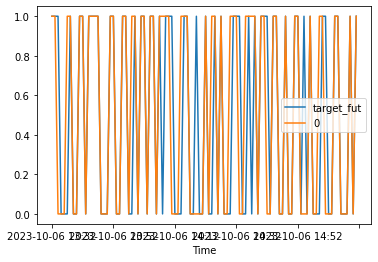

In [77]:
combined = pd.concat([test["target_fut"], preds], axis=1)
combined.plot()

In [78]:
print('\nClassification Report\n', metrics.classification_report(predictions["target_fut"], predictions["Predictions"]))


Classification Report
               precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      6459
         1.0       0.79      0.80      0.80      6361

    accuracy                           0.80     12820
   macro avg       0.80      0.80      0.80     12820
weighted avg       0.80      0.80      0.80     12820



In [79]:
predictions

target_fut  Predictions
Time                                     
2023-09-01 15:31         1.0          1.0
2023-09-01 15:32         0.0          1.0
2023-09-01 15:33         0.0          1.0
2023-09-01 15:34         1.0          1.0
2023-09-01 15:35         0.0          0.0
...                      ...          ...
2023-10-06 15:07         0.0          0.0
2023-10-06 15:08         0.0          0.0
2023-10-06 15:09         1.0          1.0
2023-10-06 15:10         0.0          0.0
2023-10-06 15:11         1.0          1.0

[12820 rows x 2 columns]

In [80]:
predictions.Predictions.value_counts()

Predictions
1.0    6441
0.0    6379
Name: count, dtype: int64

In [83]:
predictions['result'] = np.where(predictions.target_fut == predictions.Predictions, 1,0)

In [85]:
predictions.result.value_counts()

result
1    10202
0     2618
Name: count, dtype: int64

### KNN

### continuação mesclada

### continuação original

In [ ]:
##-----------------------------------slider de horas-------------------------------------------- '''

In [39]:
with col2:
	hora_previsao = st.slider("Tempo Futuro da Previsão (horas)",
				  value=1,
				  min_value=1,
				  max_value=8,
				  step=1)
with col3:
        st.write("Previsão")
with col4:
        st.write("Probabilidade")


In [ ]:
##-----------------------------------VISUALIZAÇÃO DOS DADOS-------------------------------------------- '''

In [40]:
##-----------------------------------slider de horas-------------------------------------------- '''
if st.button('Aperte para Previsão'):
    df_viz = df[-600:]
    st.markdown("")

    # Bollinger Band
    st.subheader('Visualização das features exógenas')
    figBoll = go.Figure()
    figBoll.add_trace(
        go.Scatter(
            x = df_viz.index,
        y = df_viz['upper'],
        name = "Upper Band")
        )
    figBoll.add_trace(
        go.Scatter(
        x = df_viz.index,
        y = df_viz['mid'],
        name = "Média Móvel")
        )
    figBoll.add_trace(
        go.Scatter(
            x = df_viz.index,
        y = df_viz['low'],
        name = "Lower Band")
        )
    figBoll.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1,
        xanchor="left",
        x=0
        ))
    figBoll.update_layout(title_text="Bollinger Band")
    figBoll.update_yaxes(tickprefix="$")
    st.plotly_chart(figBoll, use_container_width=False)

    # Gráfico RSI
    fig = px.line(df_viz, x=df_viz.index, y="rsi")
    fig.update_layout(title_text="Variação de RSI")
    st.plotly_chart(fig, use_container_width=False)
    ##-----------------------------------CRIANDO DATASET-------------------------------------------- '''

    df = target(df)
    df.dropna(inplace=True)
    df = df[['target', 'Close', 'Volume', 'rsi', 'bbp', 'suport_resistencia', 'corr_class', 'media_movel', 'dia_semana', 'horario', 'mes']]
    df = constroi_features_defasadas(df,['Close'],20)
    df = constroi_features_futuras(df,'target',hora_previsao)
    df_model = df.drop('target', axis=1)

    ###-----------------------------------MODELO--------------------------------------------
    if ticker == 'AAPL':
        picklefile = open("stock_pred_AAPL.pkl", "rb")
        model = pickle.load(picklefile)
    if ticker == 'AMZN':
        picklefile = open("stock_pred_AMZN.pkl", "rb")
        model = pickle.load(picklefile)

    df = df_model[-600:]
    #st.dataframe(df)
    X_test = df.drop('target_fut', axis=1)[-1:]
    #st.dataframe(X_test)
    #X_train = df[:-1].dropna().drop('target_fut', axis=1)
    #y_train = df[:-1].dropna()['target_fut']

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    #y_pred, y_proba = modelo(df, 'target_fut')

    ###-------------------------------------------------------------------------------------
    with col3:
        #st.write("Previsão")
        if y_proba >= 0.7:
            st.info('Subir ⬆️')
        elif y_proba <= 0.3:
            st.error('Descer ⬇️')
        else:
            st.warning('Na mesma 😐')

    with col4:
        #st.write("Probabilidade")
        #st.subheader(y_proba[0])
        if y_proba >= 0.7:
            st.info(round(y_proba[0],4))
        elif y_proba <= 0.3:
            st.error(round(y_proba[0],4))
        else:
            st.warning(round(y_proba[0],4))